This notebook presents an application of `Scouter` to a **smaller version** of the [Adamson](https://www.sciencedirect.com/science/article/pii/S0092867416316609) dataset, including 86 one-gene perturbations generated using Perturb-seq. Compared to the original Adamson dataset, each perturbation group (except for the control group) in this demo version is downsampled to contain less than 300 cells.

To use your own dataset, please refer to the [OwnDataTutorial](OwnDataTutorial.ipynb).

# 1. Data Setup

In [1]:
import pickle
import torch
import anndata as ad
import pandas as pd
import numpy as np
import random
from scouter import Scouter, ScouterData, adamson_small, embedding_small

# Set seeds for reproducibility
def set_seeds(seed=24):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seeds(24)

### a) Load the demo scRNA-seq dataset as Anndata

In [2]:
adata = adamson_small()
print(adata)

Adamson_small.h5ad.gz already available and uncompressed.
AnnData object with n_obs × n_vars = 28409 × 5060
    obs: 'condition'
    var: 'gene_name'


In [3]:
# check the number of cells under each genetic perturbation
print(adata.obs.condition.value_counts())

condition
ctrl            3000
SEC61A1+ctrl     300
SOCS1+ctrl       300
SLMO2+ctrl       300
SLC39A7+ctrl     300
                ... 
HARS+ctrl        272
CAD+ctrl         242
COPZ1+ctrl       220
PPWD1+ctrl       190
COPB1+ctrl       185
Name: count, Length: 87, dtype: int64


### b) Load the demo gene embedding matrix as as a `pandas.DataFrame`

Note that the embedding matrix contains an extra row of zeros for `'ctrl'`, for the generalization that `'GeneA+ctrl'` denotes a one-gene perturbation but `'GeneA+GeneB'` denotes a two-gene perturbation.

In [4]:
embd = embedding_small()
embd

Embedding_small.csv.gz already available and uncompressed.


,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
ctrl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMIGO3,-0.036371,-0.012894,-0.008276,-0.010909,-0.012836,0.011137,-0.015494,0.028140,-0.021621,-0.006081,...,0.026586,0.010099,-0.007714,-0.019805,-0.011457,0.010020,-0.006016,-0.029682,-0.012391,-0.020067
ARHGAP22,-0.039296,-0.005397,-0.002448,-0.011384,0.010381,0.021706,-0.020878,0.023169,-0.004333,-0.033446,...,0.015286,0.006449,0.002699,0.001115,-0.010607,0.022638,0.014678,-0.022975,-0.010355,0.012594
ASCC3,-0.031085,-0.010019,0.003282,-0.032561,-0.021830,0.036568,-0.007527,0.035066,-0.004436,-0.006394,...,0.042896,0.000460,-0.010184,-0.002066,-0.021369,0.011139,-0.003414,-0.014066,0.001287,-0.013881
BHLHE40,-0.041393,0.003781,-0.015254,-0.030586,-0.027794,0.007789,-0.013703,0.018990,-0.028880,-0.005607,...,0.014078,-0.008674,0.013380,0.005016,0.000319,0.006202,-0.017620,-0.006283,-0.000229,-0.006974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MARS,-0.040408,0.009426,-0.007601,-0.009777,-0.025166,0.024144,-0.015349,0.017776,-0.025126,-0.015455,...,0.014221,0.004985,-0.003781,-0.023056,-0.031706,0.030273,0.009578,-0.026877,-0.012749,0.006417
SARS,-0.024092,-0.009696,-0.032192,-0.021545,-0.017698,0.031326,-0.036157,0.030853,-0.023343,-0.010195,...,0.029094,0.002806,-0.012079,-0.006919,-0.020101,0.009092,-0.010845,-0.012971,-0.020613,-0.003433
SRPR,-0.030122,-0.015181,-0.001821,-0.019617,-0.007703,0.016814,-0.003739,0.018714,-0.021330,-0.011004,...,0.009045,0.014490,-0.007975,-0.022127,-0.027546,0.031504,0.002211,-0.024597,-0.013335,-0.001645
TARS,-0.013718,-0.041260,-0.018051,-0.032593,-0.004377,0.022544,-0.007052,0.023395,-0.010169,-0.010840,...,0.028765,0.014821,-0.012375,-0.001778,-0.008860,0.000566,-0.001836,-0.001370,-0.011226,-0.006022


# 2. Data Loader

`ScouterData` is a dataloader that combiens the gene expression and gene embeddigns together, and prepares the training of `Scouter`. The function takes as input:
- `adata`: the adata object that contains gene expression and cell annotations
- `embd`: the dataframe that contains ge
- `key_label`: The column name of `adata.obs` that corresponds to perturbation conditions
- `key_var_genename`: The column name of `adata.var` that corresponds to gene names. This is for readability of plots later, where you can show genes in their names instead of index or ensembl ids.

In [5]:
scouterdata = ScouterData(adata=adata, embd=embd, key_label='condition', key_var_genename='gene_name')

We perform the follwing necessary preprocessing for the smooth training of `Scouter` later:
- `ScouterData.setup_ad(key_embd_index)`: Setup `adata` and `embd`.
        `embd` will be filtered so that it only contains the matched genes to save memory usage.
        `adata` will drop the perturbation conditions not covered by matched genes.
        A new column named `key_embd_index` will be added to `adata.obs`, denoting the index of perturbed genes in `embd`.

- `ScouterData.gene_ranks()`: Rank genes for each perturbation group. Saved as a dictionary in `adata.uns['rank_genes_groups']`. We need this step for model measurement, because we only calculate the metric across top20 DEGs.

- `ScouterData.get_dropout_non_zero_genes()`: Compute the non-zero genes and top 20 differentially expressed genes for each perturbation group. We perform this step because in the loss function of `Scouter`, we only calculate the loss on non-zeros of each group.

- `ScouterData.split_Train_Val_Test(seed)`: split the data into three sets: Training, Validation, and Testing, based on the random seed `seed`.

In [6]:
scouterdata.setup_ad('embd_index')
scouterdata.gene_ranks()

scouterdata.generate_labels(log2fc_threshold=0.01, fdr_threshold=0.05)
top20_gene_sets = scouterdata.get_degs_by_direction(n_genes=20)
scouterdata.split_Train_Val_Test(seed=1)

All 87 perturbed genes are found in the gene embedding matrix!


## 3. `Scouter` Training

We train `Scouter` model on `scouterdata`. This is a supervised training, so we would recommend a hyperparameter searching based on the metrics on validation set for both `Scouter.model_init()` and `Scouter.train()`. However, across the experiments on five different datasets in our work, we notice most hyparameters are not sensitive. Therefore, users are welcome to start with our default parameters. For a efficient searching, we recommend targeting on these parameters:
- `loss_gamma` in `Scouter.train()`: $\gamma$ in $L_\text{autofocus}$. `loss_gamma=0` denotes MSE loss. `loss_gamma=0` returns the best result on all five datasets in our work.
- `loss_lambda` in `Scouter.train()`: $\lambda$ in $L=L_\text{autofocus}+\lambda L_\text{direnction}$
- `lr` in `Scouter.train()`: learning rate
- gene embedding source: In this example, we use the embeddings provided by [GenePT](https://github.com/yiqunchen/GenePT). However, there are some other embeddings available online. The author of [scELMo](https://sites.google.com/yale.edu/scelmolib) collected a series of embeddings for biological terms.

In [7]:
# Calculate class weights to handle imbalance
labels = scouterdata.train_adata.varm['labels'].values.flatten()
class_counts = np.bincount(labels + 1)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()

In [8]:
scouter_model = Scouter(scouterdata)
scouter_model.model_init()
scouter_model.train(alpha=class_weights, gamma=2.0)

Epoch 1/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 25.34batch/s]


Epoch 1/40, Training Loss: 0.0079, Validation Loss: 0.0016


Epoch 2/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 24.94batch/s]


Epoch 2/40, Training Loss: 0.0012, Validation Loss: 0.0013


Epoch 3/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 22.75batch/s]


Epoch 3/40, Training Loss: 0.0010, Validation Loss: 0.0012


Epoch 4/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 25.57batch/s]


Epoch 4/40, Training Loss: 0.0009, Validation Loss: 0.0011


Epoch 5/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 24.88batch/s]


Epoch 5/40, Training Loss: 0.0009, Validation Loss: 0.0011


Epoch 6/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 25.26batch/s]


Epoch 6/40, Training Loss: 0.0008, Validation Loss: 0.0010


Epoch 7/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 23.49batch/s]


Epoch 7/40, Training Loss: 0.0009, Validation Loss: 0.0010


Epoch 8/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 25.07batch/s]


Epoch 8/40, Training Loss: 0.0008, Validation Loss: 0.0010


Epoch 9/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 23.38batch/s]


Epoch 9/40, Training Loss: 0.0008, Validation Loss: 0.0010


Epoch 10/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 24.89batch/s]


Epoch 10/40, Training Loss: 0.0008, Validation Loss: 0.0010


Epoch 11/40 - Validation Batches: 100%|██████████| 9/9 [00:00<00:00, 22.97batch/s]

Epoch 11/40, Training Loss: 0.0008, Validation Loss: 0.0010
Early stopping after 11 epochs


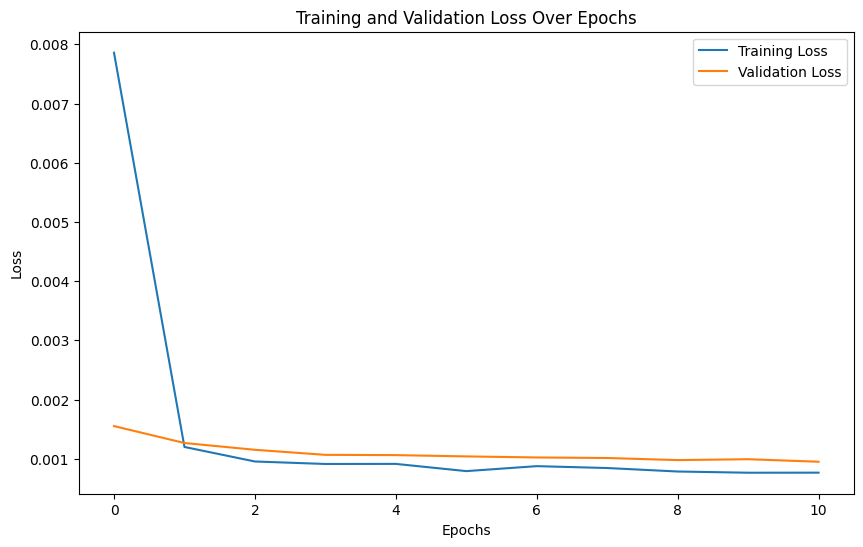

In [9]:
import matplotlib.pyplot as plt
loss_history = scouter_model.loss_history
plt.figure(figsize=(10, 6))
plt.plot(loss_history['train_loss'], label='Training Loss')
plt.plot(loss_history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4. Model Prediction

To make predictions on specific gene perturbations, we can use `Scouter.pred` with parameters:
- `pert_list`: a list of perturation names for prediction
- `n_pred`: how many control cells sampled to make the prediction. The resulting prediciton matrix for each perturbation would have shape of `[n_pred, n_genes]`
- `seed`: reproduce the prediction result by setting a seed.

It returns a dictionary with perturbation as keys, and the corresponding predicted transcriptome as values.
Users may average aggregation to achieve a point estimator such as `pred_dict['ATP5B+ctrl'].mean(axis=0)`

In [10]:
pred_dict = scouter_model.pred(['ATP5B+ctrl', 'MANF+ctrl'])
print("Predicted probabilities for ATP5B+ctrl:")
print(pred_dict['ATP5B+ctrl'])

Predicted probabilities for ATP5B+ctrl:
[[0.02036504 0.95914835 0.02048655]
 [0.02006171 0.96084565 0.01909261]
 [0.01955635 0.9584633  0.02198029]
 ...
 [0.02076783 0.95849913 0.02073301]
 [0.66474074 0.3325354  0.00272385]
 [0.96220875 0.01833582 0.01945543]]


## 5. Model Evaluation

In [11]:
metrics_df = scouter_model.evaluate()
print("Evaluation metrics on the test set:")
print(metrics_df)

Evaluation metrics on the test set:
    Perturbation  Accuracy  Precision    Recall  F1-score  \
0   BHLHE40+ctrl  0.958893   0.863185  0.976046  0.909433   
1      HARS+ctrl  0.950791   0.844098  0.975084  0.896491   
2     ATP5B+ctrl  0.956126   0.838652  0.974108  0.890663   
3     DERL2+ctrl  0.952767   0.846604  0.971943  0.896409   
4     TELO2+ctrl  0.947036   0.841415  0.967368  0.892171   
5    MRPL39+ctrl  0.954150   0.841477  0.973933  0.893283   
6      MANF+ctrl  0.960079   0.862204  0.975993  0.908448   
7      TARS+ctrl  0.946838   0.852849  0.970738  0.901376   
8      TTI1+ctrl  0.953557   0.850538  0.975310  0.900894   
9     SRP72+ctrl  0.960079   0.849945  0.977416  0.900183   
10    SCYL1+ctrl  0.942885   0.830698  0.962673  0.882728   
11    HYOU1+ctrl  0.957905   0.848633  0.975209  0.898489   
12   TMED10+ctrl  0.951383   0.851819  0.973294  0.901199   
13    CCND3+ctrl  0.960870   0.867477  0.977640  0.912958   
14    COPB1+ctrl  0.892885   0.766004  0.951262  

In [12]:
focused_metrics_df = scouter_model.analyze_20DEGs(top20_gene_sets)
print("Focused Metrics on Top 20 DEGs")
print(focused_metrics_df)

Focused Metrics on Top 20 DEGs
    Perturbation Direction                    confusion_matrix
0   BHLHE40+ctrl        up  [[0, 0, 0], [0, 0, 0], [0, 0, 20]]
1   BHLHE40+ctrl      down  [[0, 0, 0], [0, 20, 0], [0, 0, 0]]
2      HARS+ctrl        up  [[0, 0, 0], [0, 0, 0], [0, 0, 20]]
3      HARS+ctrl      down  [[0, 0, 0], [0, 20, 0], [0, 0, 0]]
4     ATP5B+ctrl        up  [[0, 0, 0], [0, 0, 0], [0, 0, 20]]
5     ATP5B+ctrl      down  [[0, 0, 0], [0, 20, 0], [0, 0, 0]]
6     DERL2+ctrl        up  [[0, 0, 0], [0, 0, 0], [0, 0, 20]]
7     DERL2+ctrl      down  [[0, 0, 0], [0, 20, 0], [0, 0, 0]]
8     TELO2+ctrl        up  [[0, 0, 0], [0, 0, 0], [0, 0, 20]]
9     TELO2+ctrl      down  [[0, 0, 0], [0, 20, 0], [0, 0, 0]]
10   MRPL39+ctrl        up  [[0, 0, 0], [0, 0, 0], [0, 0, 20]]
11   MRPL39+ctrl      down  [[0, 0, 0], [0, 20, 0], [0, 0, 0]]
12     MANF+ctrl        up  [[0, 0, 0], [0, 0, 0], [0, 0, 20]]
13     MANF+ctrl      down  [[0, 0, 0], [0, 20, 0], [0, 0, 0]]
14     TARS+ctrl        